In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.1163
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

In [3]:
def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15_multiMethod_Nsrc=50/data_merge/NpiScatteringWilson.h5'
data={}
with h5py.File(path) as f:
    for cont in f['data'].keys():
        if cont in ['N']:
            t=f[f'data/{cont}'][:,:,16]
            t=symmetrize(t)
            data[cont]=yu.jackknife(t)
            continue
        if cont in ['P','P_hybrid']:
            t=f[f'data/{cont}'][:,:,0]
            t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
            t=(t+t_bw)/2
            data[cont]=yu.jackknife(t)
            continue
        t=f[f'data/{cont}'][:,:,0]
        t=symmetrize(t)
        data[cont]=yu.jackknife(t)

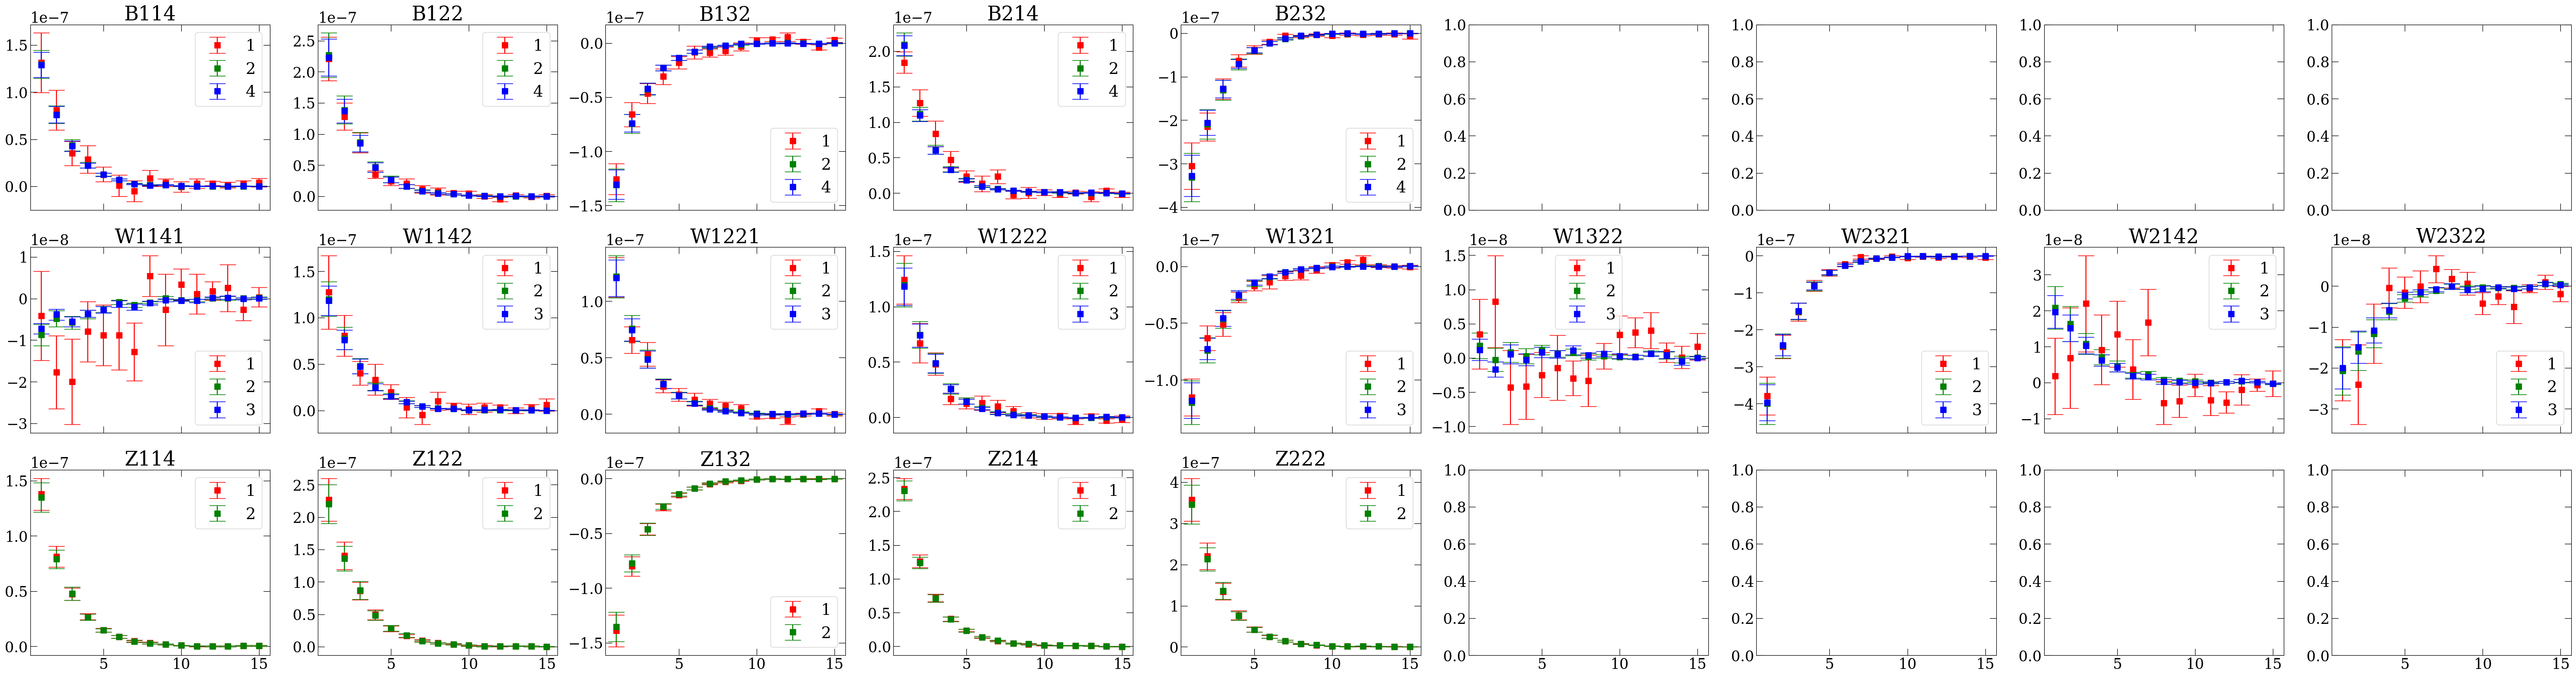

In [4]:
contss=[
    ['B114','B122','B132','B214','B232'],
    ['W1141','W1142','W1221','W1222','W1321','W1322','W2321','W2142','W2322'],
    ['Z114','Z122','Z132','Z214','Z222']
]

fig, axs = yu.getFigAxs(3,9, sharex=True)
colors=['r','g','b','purple']
tmin=1; tmax=16
for iconts,conts in enumerate(contss):
    topo=conts[0][0]
    methods={
        'B':['1','2','4'],
        'W':['1','2','3'],
        # 'B':['2','4'],
        # 'W':['2','3'],
        'Z':['1','2']
    }[topo]
    
    for icont, cont in enumerate(conts):
        ax=axs[iconts,icont]
        ax.title.set_text(f'{cont}')
        for i,method in enumerate(methods):
            dat=np.real(data[f'{cont}_{method}'])
            
            if len(dat.shape)==3:
                # if topo in ['B','W']:
                #     if method == '2':
                #         dat=dat[:,:,:1]
                #     if method in ['3','4']:
                #         dat=dat[:,:,:1]
                #         dat=dat[:,:,:,:1]
                t=np.mean(dat,axis=2)
            else:
                t=np.mean(dat,axis=2)
                t=np.mean(t,axis=2)
            mean,err=yu.jackme(t)
            plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i],label=method)
                
        ax.legend()
        # ax.set_yscale('log')

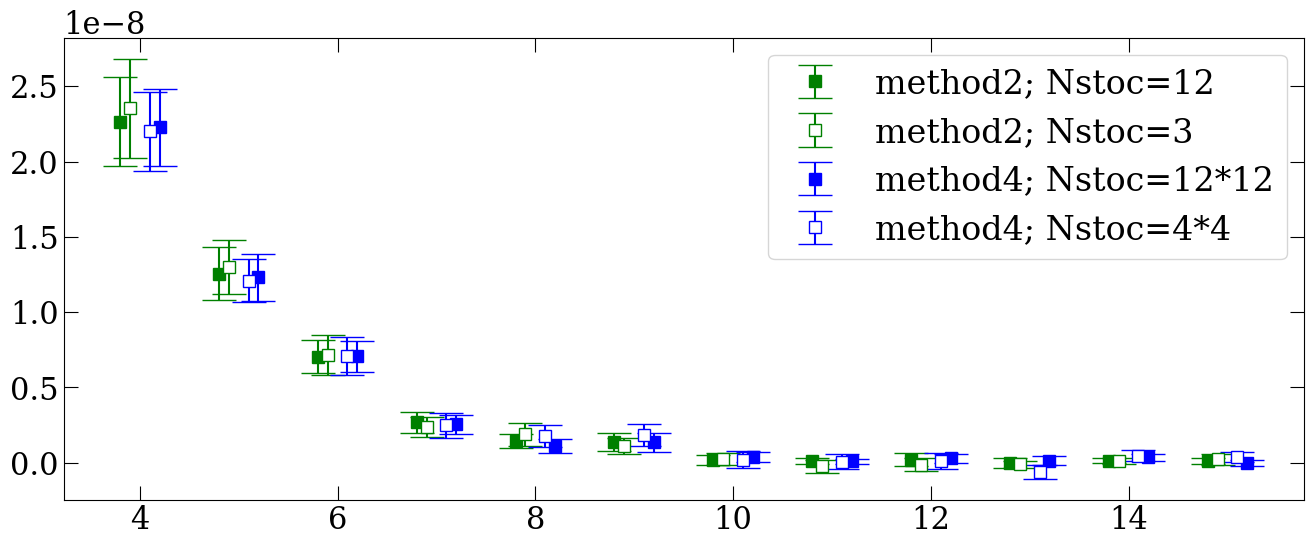

In [5]:
fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16,sharex=True,sharey=True)

cont='B114'
tmin=4; tmax=16

ax=axs[0,0]

# Nstoc=12
# dat=np.real(data[f'{cont}_1'])
# t=np.mean(dat[:,:,:Nstoc],axis=2)
# mean,err=yu.jackme(t)
# plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r',label=f'method1; Nstoc={Nstoc}')

Nstoc=12
dat=np.real(data[f'{cont}_2'])
t=np.mean(dat[:,:,:Nstoc],axis=2)
mean,err=yu.jackme(t)
plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
ax.errorbar(plt_x-0.2,plt_y,plt_yerr,color='g',label=f'method2; Nstoc={Nstoc}')

Nstoc=3
dat=np.real(data[f'{cont}_2'])
t=np.mean(dat[:,:,:Nstoc],axis=2)
mean,err=yu.jackme(t)
plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
ax.errorbar(plt_x-0.1,plt_y,plt_yerr,color='g',label=f'method2; Nstoc={Nstoc}', mfc='white')

Nstoc=(12,12)
dat=np.real(data[f'{cont}_4'])
t=np.mean(np.mean(dat[:,:,:Nstoc[0]][:,:,:,:Nstoc[1]],axis=2),axis=2)
mean,err=yu.jackme(t)
plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
ax.errorbar(plt_x+0.2,plt_y,plt_yerr,color='b',label=f'method4; Nstoc={Nstoc[0]}*{Nstoc[1]}')

Nstoc=(4,4)
dat=np.real(data[f'{cont}_4'])
t=np.mean(np.mean(dat[:,:,:Nstoc[0]][:,:,:,:Nstoc[1]],axis=2),axis=2)
mean,err=yu.jackme(t)
plt_x=np.arange(tmin,tmax); plt_y=mean[tmin:tmax]; plt_yerr=err[tmin:tmax]
ax.errorbar(plt_x+0.1,plt_y,plt_yerr,color='b',label=f'method4; Nstoc={Nstoc[0]}*{Nstoc[1]}', mfc='white')

ax.legend()

In [8]:
# sigma term to lattice scattering length 1/2 # Hoferichter:2016ocj
mpiC_phys=139.57
sgm_center=59.1
a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)
a12_center_pheLat=178.8*1e-3 * (mpiC_phys**-1); a12_error_pheLat=3.8*1e-3 * (mpiC_phys**-1)
a32_center_pheLat=-77.5*1e-3 * (mpiC_phys**-1); a32_error_pheLat=3.5*1e-3 * (mpiC_phys**-1)

def a2sgm(a12,a32):
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return sgm_center + c12*(a12-a12_center) + c32*(a32-a32_center)

def sgm2a12(sgm):    
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return a12_center + (sgm-sgm_center)/c12

# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    return yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)

mN=931; mpi=131
mu=1/(1/mN+1/mpi); L=4.5 * hbarc

print(f'1/2: {sl2es(mu,L,a12_center)}, 3/2: {sl2es(mu,L,a32_center)}')

for sgm in [40,60]:
    print(f'{sgm}: {sl2es(mu,L,sgm2a12(sgm))}')
    
es2sl(mu,L,-5),a12_center

# a2sgm(0.169*mpiC_phys**-1/2,-0.1*mpiC_phys**-1)

a2sgm(0.123*(mpiC_phys**-1),-0.098*(mpiC_phys**-1))

1/2: -4.86473912395479, 3/2: 3.085302012686854
40: -2.775974591170151
60: -4.956882313254664


37.54860000000001

In [9]:
mN=938/lat_aInv
mpi=140/lat_aInv
mu=1/(1/mN+1/mpi) 
L=48

def sl2es(a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(dE):
    return yu.fsolve2(lambda a0:sl2es(a0)-dE, 0)


a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)

-1,0.0019946534,0.0027410528,0.00426809,0.0048872326,0.007966004,0.0191001,0.026648492,0.036681883,0.105062924,0.12882628,0.15679055,0.3250969,1.1848009,1.2326428,-1,-1,1.4120369,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.28971174,0.28145236,0.16764534,0.096847765,0.047281176,0.019752573,0.012042753,0.0058886595,-1


(0.98, 1.02)

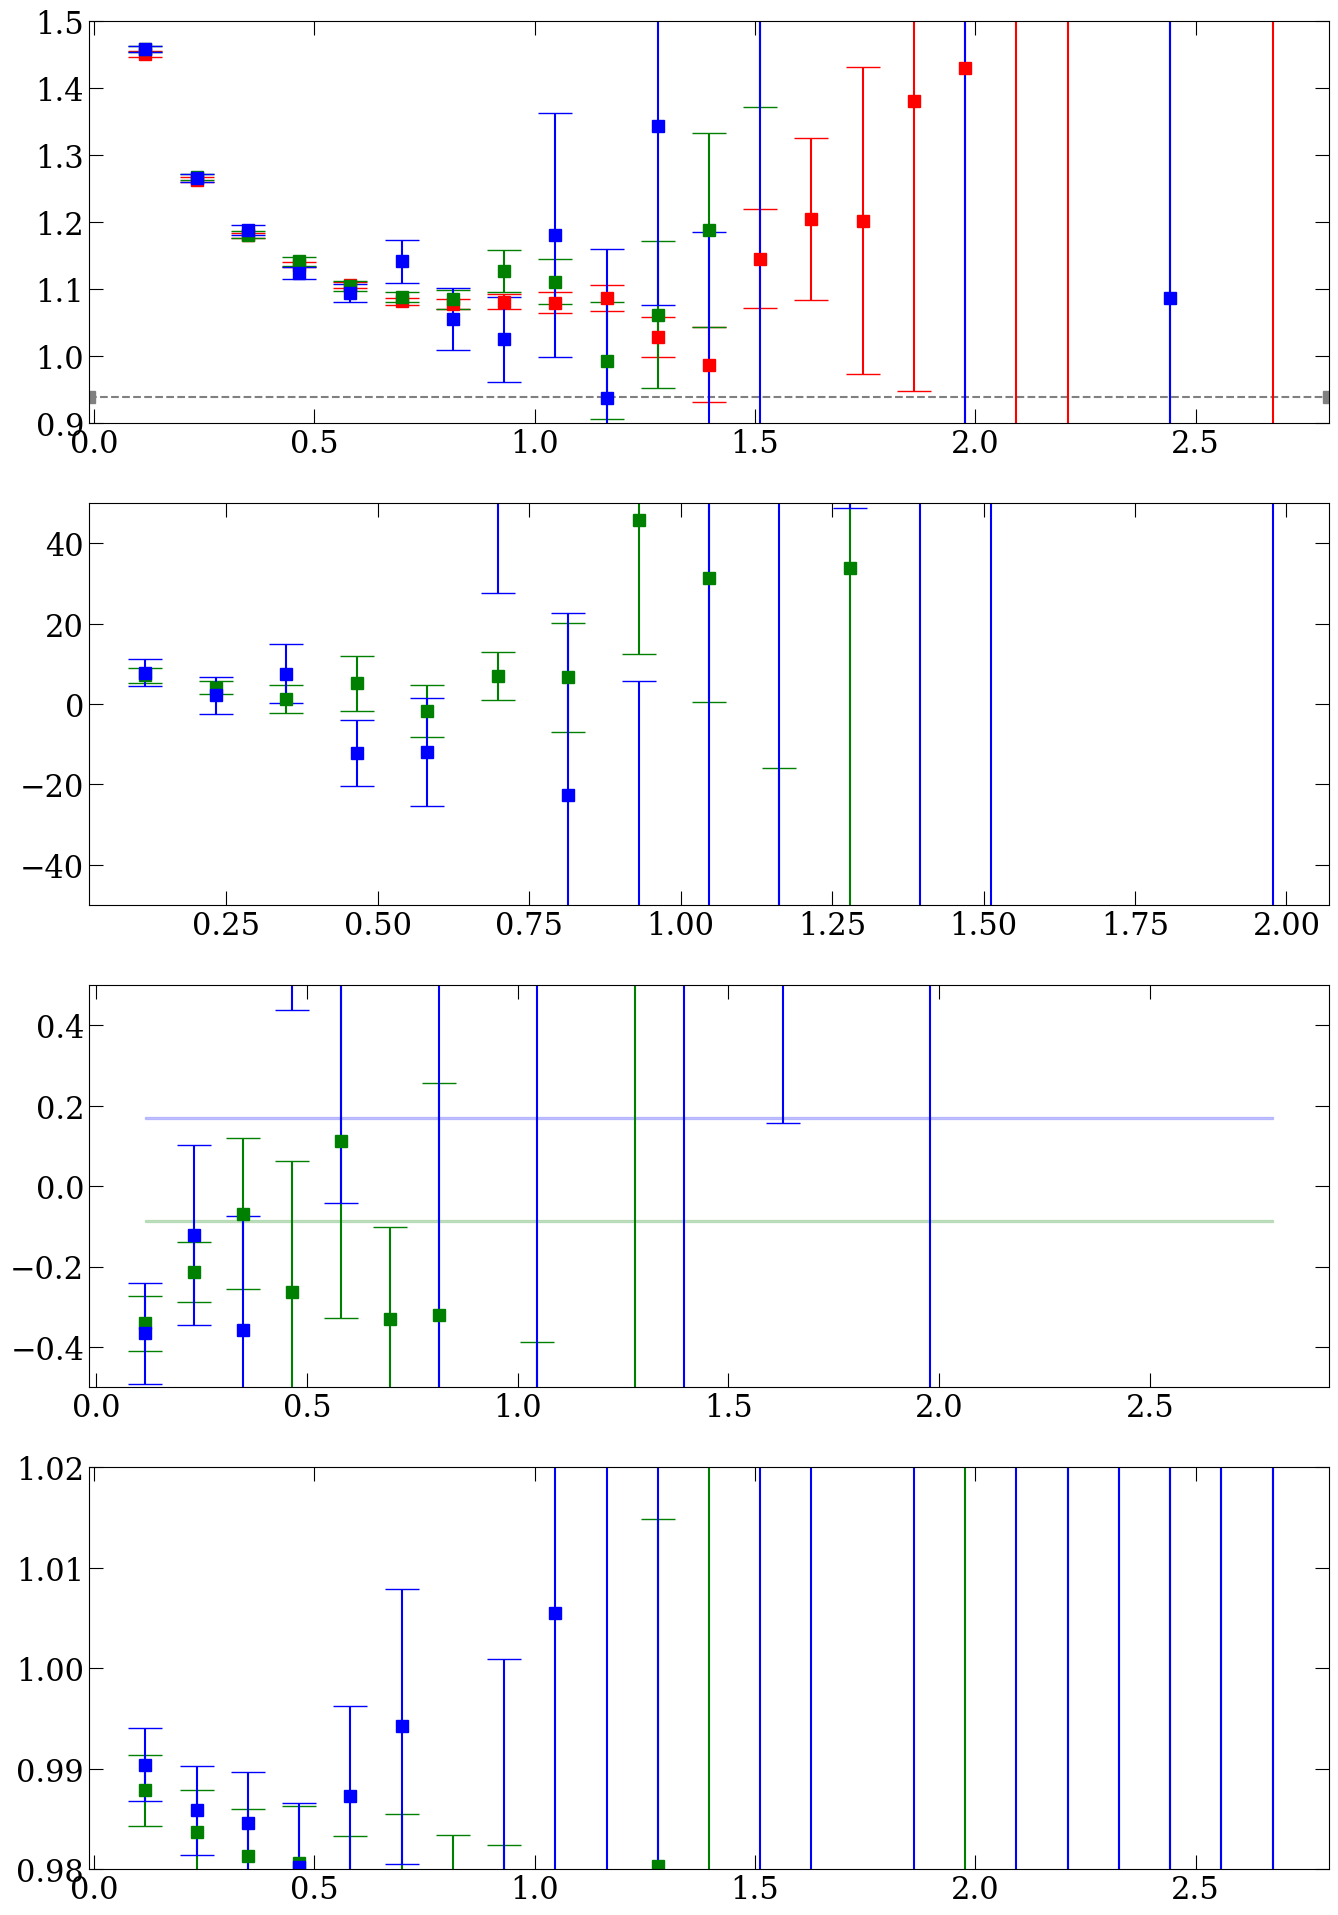

In [10]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['1','1','1']

c_12=np.real(data['M'][:,:,0]+np.mean(np.sum([cont[0]*data[f'{cont[1]}_{method}']  for conts,method in zip(coeffs_12,method) for cont in conts],axis=0),axis=2))
c_32=np.real(data['M'][:,:,0]+np.mean(np.sum([cont[0]*data[f'{cont[1]}_{method}']  for conts,method in zip(coeffs_32,method) for cont in conts],axis=0),axis=2))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

func=lambda c:np.log(c/np.roll(c,-1))
m_12=yu.jackmap(func,c_12)
m_32=yu.jackmap(func,c_32)
m_Npi=yu.jackmap(func,c_Npi)
m_N=yu.jackmap(func,c_N)
m_pi=yu.jackmap(func,c_pi)

func=lambda dEs:[es2sl(dE) for dE in dEs]
a_32=yu.jackmap(func,m_32-m_Npi)
a_12=yu.jackmap(func,m_12-m_Npi)

fig, axs = yu.getFigAxs(4,1,Lrow=6,Lcol=16)

ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24
ax.set_ylim([0.9,1.5])
ax.axhline(0.938,color='grey',ls='--')


mean,err=yu.jackme(m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(m_32)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([-50,50])

mean,err=yu.jackme(m_32-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

print(','.join([str(ele) if not np.isnan(ele) else '-1' for ele in err]))

ax=axs[2,0]
xunit=lat_a; yunit=mpi
ax.set_ylim([-0.5,0.5])

plt_x=np.array([tmin,tmax])*xunit; plt_y=-86.3*1e-3; plt_yerr=1.8*1e-3
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='g',alpha=0.2)  
plt_x=np.array([tmin,tmax])*xunit; plt_y=169.8*1e-3; plt_yerr=2.0*1e-3
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)  

mean,err=yu.jackme(a_32)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(a_12)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')


ax=axs[3,0]
xunit=lat_a; yunit=1

mean,err=yu.jackme(c_32/c_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(c_12/c_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax.set_ylim([0.98,1.02])

800 nh for 200*50

Delta: 400*256

Polarizability: 200*1024

<ErrorbarContainer object of 3 artists>

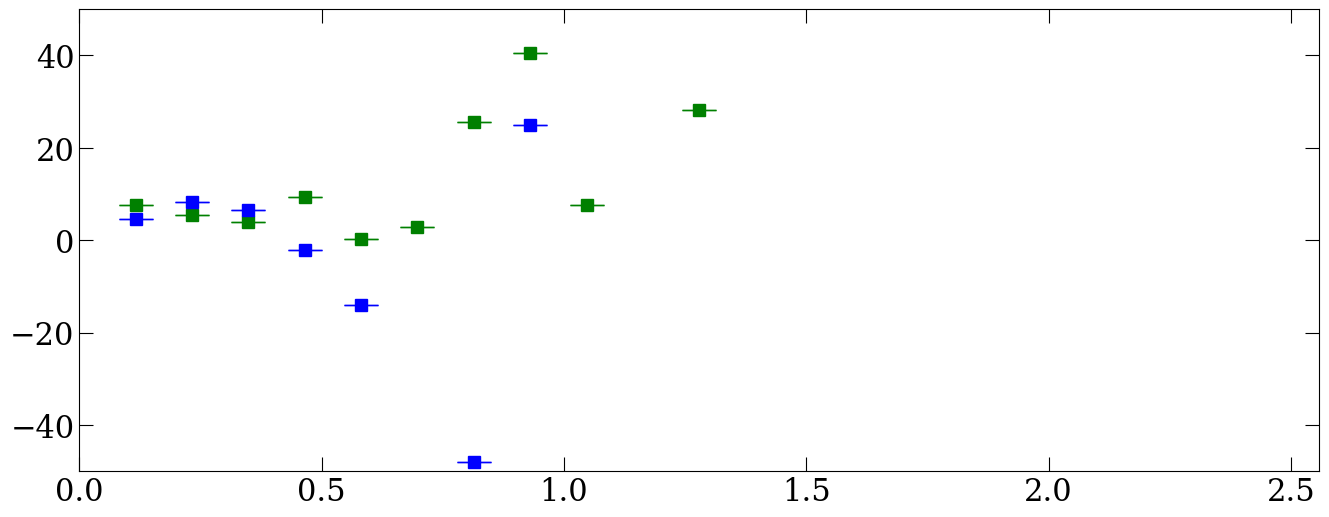

In [9]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['1','1','1']

def func(dat):
    Ncfg=len(dat)
    return np.repeat(np.mean(dat,axis=0)[None,:],Ncfg,axis=0)
c=[np.real(data['M'][:,:,0])]+[np.real(np.sum([cont[0]*np.mean(data[f'{cont[1]}_{method}'],axis=2) for cont in conts],axis=0)) for conts,method in zip(coeffs_12,method)]
c=[func(c[0]),func(c[1]),func(c[2]),func(c[3])]
c_12=np.sum(c,axis=0)

c=[np.real(data['M'][:,:,0])]+[np.real(np.sum([cont[0]*np.mean(data[f'{cont[1]}_{method}'],axis=2) for cont in conts],axis=0)) for conts,method in zip(coeffs_32,method)]
c=[func(c[0]),func(c[1]),func(c[2]),func(c[3])]
c_32=np.sum(c,axis=0)

c_Npi=func(np.real(data['N']*data['P']))
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

func=lambda c:np.log(c/np.roll(c,-1))
m_12=yu.jackmap(func,c_12)
m_32=yu.jackmap(func,c_32)
m_Npi=yu.jackmap(func,c_Npi)
m_N=yu.jackmap(func,c_N)
m_pi=yu.jackmap(func,c_pi)

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)

ax=axs[0,0]
tmin=1; tmax=24
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([-50,50])

mean,err=yu.jackme(m_32-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
